# Stable MM toy
Proof of concept for rigging MM without making noticeable difference against completely random MM

In [1]:
import random
import numpy as np

Set number of player pools here. Player initial winrate is drawn from a truncated normal distribution. A simple normal risk an out-of-bound error.

~~Use `pool_size = 100` and `seed = 50` for a significantly deviating average (52%)~~ Doesn't actually matter, since outliers is being skewered in regardless of average.

In [18]:
from scipy.stats import truncnorm
pool_size = 100

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

np.random.seed(10)
# participants = np.random.normal(loc=0.5, scale=0.2, size=pool_size)
participants = get_truncated_normal(mean=0.5, sd=0.2, low=0.1, upp=0.9).rvs(pool_size)
outlier = np.logical_or(participants >= 1.0, participants <= 0.0)
#print(participants, outlier, np.any(outlier))
assert not np.any(outlier), "Error value: {}".format(participants[outlier])

In [32]:
# Come back to this cell when done copying syn_wrt -> participants
print("Stat: avg: {:.4f}, log avg: {:.4f}".format(np.mean(participants) * 100.0, np.exp(np.mean(np.log(participants))) * 100.0))

Stat: avg: 50.0198, log avg: 49.5365


After a set number of run, currently very large outliers (<30%) is being heavily skewered back into normal from any current variation of Bayes; suggesting that the impact of very good/very bad players are limited.

## Winrate calculator
Currently using Naive Bayes. Essentially, we are assuming player contribution is completely independent of each other, so we can chain their probability together (winning team's winrate * losing team's loss rate / winning team total winloss * losing team total winloss).

In practice, a barebone implementation is currently smoothing out outliers, due to their percentage being "drowned out" by the other players in the team approximating 50%. We will need a scaling factor to account for this; so far, the higher scaling factor, the more of the model is "disuaded" from moving toward the mean.

In [4]:
def independent_team(team):
    # calculate by bayes
    lose_perc = [1.0-v for v in team]
    win_self = np.prod(team)
    loss_self = np.prod(lose_perc)
    return win_self / (win_self + loss_self), loss_self / (win_self + loss_self)
# win rate calculation using previous fn for attacking team
def wincalc(atk, dfn):
    atk_win, atk_loss = independent_team(atk)
    def_win, def_loss = independent_team(dfn)
    # print(atk_win, atk_loss, def_win, def_loss)
    true_win = atk_win * def_loss
    true_loss = def_win * atk_loss
    return true_win / (true_win + true_loss)

def win_calc_alt(atk, dfn):
    # full usage of naive bayes
    atk_loss = np.array([1.0 - v for v in atk])
    dfn_loss = np.array([1.0 - v for v in dfn])
    true_win = np.prod(atk) * np.prod(dfn_loss)
    true_loss = np.prod(atk_loss) * np.prod(dfn)
    return true_win / (true_win + true_loss)

def win_calc_log(atk, dfn):
    atk_loss = np.array([1.0 - v for v in atk])
    dfn_loss = np.array([1.0 - v for v in dfn])
    law, lal, ldw, ldl = [np.log(a) for a in [atk, atk_loss, dfn, dfn_loss]]
    lwin = np.sum(law) + np.sum(ldl)
    lloss = np.sum(lal) + np.sum(ldw)
    # centering to avoid possible accuracy losses
    center = (lwin+lloss) / 2
    true_win = np.exp(lwin - center)
    true_loss = np.exp(lloss - center)
    return true_win / (true_win + true_loss)

In [5]:
sample = participants[:10:2], participants [-9::2]
print(sample, "\n", wincalc(*sample), "\n", win_calc_alt(*sample), "\n", win_calc_log(*sample))

(array([0.49741673, 0.37537423, 0.44042396, 0.45571165, 0.63406972]), array([0.55486639, 0.54949046, 0.5184703 , 0.49994815, 0.37964754])) 
 0.4040700875675941 
 0.4040700875675941 
 0.40407008756759444


Let's first add a flat multiplier to the log value

In [6]:
def flat_mod_calculator(atk, dfn, logmod=1.5):
    # rescale values at log level by power
    bayes_wr = win_calc_alt(atk, dfn)
    mod_wr, mod_lr = bayes_wr ** logmod, (1.0 - bayes_wr) ** logmod
    return mod_wr / (mod_wr + mod_lr)

The fact that up to `logmod = 10.0` make the model more stable, yet the majority of differences sign point at 0.5 suggesting this is only an ad-hoc solution and not a true approximation.

## Random MM
Fairly straightforward: draw the 2x number for two team, use calculator above for winrate, roll, export result.

In [30]:
def create_random_match(participants, preset_ids=None, num_player=5, wr_calc=wincalc, randomizer=np.random.rand):
    # preset_ids is to prevent creating random indices for every run.
    ids = preset_ids if preset_ids is not None else [i for i in range(len(participants))]
    # sample 2x numplayer from pool, and split
    match_idx = np.random.choice(ids, num_player*2)
    match = participants[match_idx]
    atk, dfn = match[:num_player], match[num_player:]
    # calculate winrate
    win_rate = wr_calc(atk, dfn)
    # roll for result
    result = randomizer() < win_rate
    return match_idx[:num_player], match_idx[num_player:], result

create_random_match(participants)

(array([ 8, 24, 67, 87, 79]), array([48, 10, 94, 52, 98]), True)

## Synthetic data
Using the functions above, we would use our completely random MM to calculate actual winning values. Win/Total is recorded into variables; `total_game` and `seed` can be set to arbitrary number.

We can also add a customized variable function in `wr_calculator`, this allow us to modify the winrate formula on-the-fly

In [31]:
np.random.seed(100)
total_game = 35000
win, total = np.zeros_like(participants, dtype=float), np.zeros_like(participants, dtype=float) 
# custom calculator
wr_calculator = lambda a, d: flat_mod_calculator(a, d, logmod=5.0)
# precalc indices
preset_ids = [i for i in range(len(participants))]
# run {total_game}
for _ in range(total_game):
    atk, dfn, atk_win = create_random_match(participants, preset_ids=preset_ids, num_player=15, wr_calc=wr_calculator)
    total[atk] += 1 # don't try atk + dfn like the dumbass me did
    total[dfn] += 1
    if(atk_win):
        win[atk] += 1
    else:
        win[dfn] += 1
# calculate synthesized winning rate
syn_wrt = np.divide(win, total)
for t, s, a in zip(participants, syn_wrt, total):
    print("True/Synthesized wr: {:.2f} {:.2f} ({:s}{:2.2f}) over {:d}".format(
            t * 100.0, s * 100.0, "+" if s > t else "-", abs(s-t) * 100, int(a)))

True/Synthesized wr: 55.16 54.92 (-0.24) over 9668
True/Synthesized wr: 34.97 35.15 (+0.17) over 9785
True/Synthesized wr: 53.44 53.61 (+0.16) over 9775
True/Synthesized wr: 55.02 54.94 (-0.08) over 9908
True/Synthesized wr: 50.48 50.45 (-0.03) over 9899
True/Synthesized wr: 45.17 45.34 (+0.16) over 9729
True/Synthesized wr: 44.84 45.08 (+0.24) over 9727
True/Synthesized wr: 55.25 55.35 (+0.10) over 9693
True/Synthesized wr: 43.80 44.30 (+0.50) over 9888
True/Synthesized wr: 40.69 41.35 (+0.66) over 9775
True/Synthesized wr: 53.36 52.83 (-0.54) over 9896
True/Synthesized wr: 62.54 62.25 (-0.29) over 9840
True/Synthesized wr: 31.65 31.12 (-0.52) over 9568
True/Synthesized wr: 49.83 49.52 (-0.31) over 9828
True/Synthesized wr: 56.09 55.07 (-1.02) over 9987
True/Synthesized wr: 53.50 54.32 (+0.82) over 9758
True/Synthesized wr: 54.87 55.05 (+0.17) over 9939
True/Synthesized wr: 47.30 48.75 (+1.45) over 9676
True/Synthesized wr: 61.96 62.65 (+0.69) over 9599
True/Synthesized wr: 53.89 53.2

## Visualize result
This section should put out two simple histogram on distribution of current winrate (original and synthesized), as well as their normal/true and signed difference. (true is just difference, while signed will be positive if the synthesize data goes toward 50% and negative otherwise)

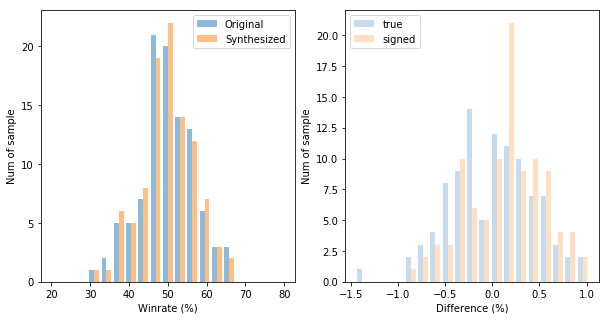

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

perc_orig, perc_syn = participants * 100, syn_wrt * 100
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
bins = np.linspace(20, 80, 20)
ax1.hist([perc_orig, perc_syn], bins, alpha=0.5, label=['Original', 'Synthesized'])
ax1.legend(loc='upper right')
ax1.set(xlabel='Winrate (%)', ylabel='Num of sample')

diff = perc_orig - perc_syn
signs = np.array([1 if avg > 50.0 else -1 for avg in ((perc_orig + perc_syn) / 2.0)])
signed = diff * signs
# remove the cases where synthesized data crosses the 50% threshold
not_crossing = (participants - 0.5) * (syn_wrt - 0.5) > 0
signed = signed[not_crossing]
diff_bins = np.linspace(np.min(diff), np.max(diff), 20)
ax2.hist([diff, signed], diff_bins, alpha=0.25, label=['true', 'signed'])
ax2.legend(loc='upper left')
ax2.set(xlabel='Difference (%)', ylabel='Num of sample')

plt.show()

In [24]:
# use the synthesized win rate to try again
participants = syn_wrt